Correlation of L, M: 
0.5458459372910968


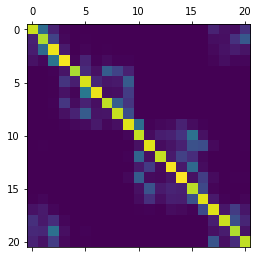

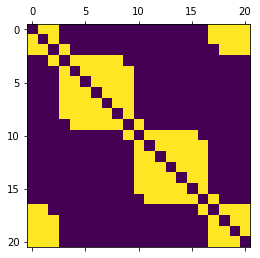

In [2]:
import pandas
import csv
import matplotlib.pyplot as plt
import learn
import util
import numpy as np
import numpy.linalg as la
import scipy as sp
import scipy.spatial.distance as dist
import sys
sys.path.append ('/Users/Zhonghou/Desktop/General/Preston Lab/tesser_successor')

from tesser import network

nodes = network.node_info()
adjacency = network.adjacency (nodes)

alpha = .5
gamma = .5

# makes the envstep necessary for learn.py
def make_envstep (directory):
    envstep = []
    objects = util.get_objects (directory)
    for index in range (len (objects)):
        obj = objects.iat[index,0]
        try:
            envstep.append (int(obj))
        except:
            pass
    return envstep

def copy (list0):
    list1 = []
    for index in range (len(list0)):
        list1.append (list0[index])
    return list1

def explore_runs (option):
    
    SR_matrices = []
    
    # This loop adds the address, part number and run number to the runs array, so that the object
    #     sequence in each run can be inputted to the learning agent.
    runs = []
    directory = '/Users/Zhonghou/Desktop/General/Preston Lab/tesser_successor/tesserScan_100_B/'
    for part_num in [1]:
        for run_num in [1,2,3,4,5]:
            filename = 'tesserScan_100_B_StructLearn_Part%s_Run_%s.txt'%(part_num, run_num)
            runs.append ([directory+filename, part_num, run_num])
    
    # This option allows the SR matrix to persist across all runs from Part 1 and Part 2
    #     without ever resetting.
    if option == 'persist':
        M = np.zeros([21,21])
        for run in runs:
            part_num, run_num = run[1], run[2]
            envstep = make_envstep (run[0])
            M = np.array(learn.run_experiment(envstep, gamma, alpha, copy(M)))
            SR_matrices.append (M)
            
    if option == 'repeat':
        M = np.zeros([21,21])
        for time in range (100):
            for run in runs:
                part_num, run_num = run[1], run[2]
                envstep = make_envstep (run[0])
                M = np.array (learn.run_experiment (envstep, gamma, alpha, copy(M)))
        return M
            
    # This option allows the SR matrix to persist in Part 1 and Part 2, but resets it between them.
    if option == 'reset':
        M = np.zeros ([21,21])
        is_reset = False
        for run in runs:
            part_num, run_num = run[1], run[2]
            if not is_reset and part_num == 2:
                M = np.zeros ([21,21])
                is_reset = True
            envstep = make_envstep (run[0])
            M = np.array(learn.run_experiment(envstep, gamma, alpha, copy(M)))
            SR_matrices.append (M)
    
    # This option resets the SR matrix between each run.
    if option == 'independent':
        for run in runs:
            part_num, run_num = run[1], run[2]
            M = np.zeros([21,21])
            envstep = make_envstep (run[0])
            M = learn.run_experiment(envstep, gamma, alpha, M)
            SR_matrices.append (M)

    # This option forces the SR matrix to persist across all runs, but instead of plotting the SR matrix
    #     after each run, it plots the changes made to it after learning each object sequence.
    if option == 'track changes':
        M = np.zeros([21,21])
        for run in runs:
            part_num, run_num = run[1], run[2]
            envstep = make_envstep (run[0])
            M_new = np.copy(M)
            M_new = learn.run_experiment(envstep, gamma, alpha, M_new)
            SR_matrices.append (M)
            M = M_new
            
    return SR_matrices

# Modify the option in the following call to the main function in order to visualize the desired learning
#     sequence.
# explore_runs('track changes')

# df.loc[[4,17],'connect'] = 1
# df.loc[[3,11],'connect'] = 2
# df.loc[[10,18],'connect'] = 3

class Node:
    comm = {1:[1,2,3,18,19,20,21],
            2:[4,5,6,7,8,9,10],
            3:[11,12,13,14,15,16,17]}
    
    def __init__ (self, index):
        self.index = index
        self.connections = []
    
    def update_connections (self):
        if self.index == 4:
            self.connections = [5,6,7,8,9,17]
        elif self.index == 17:
            self.connections = [12,13,14,15,16,4]
        elif self.index == 3:
            self.connections = [1,2,19,20,21,11]
        elif self.index == 11:
            self.connections = [12,13,14,15,16,3]
        elif self.index == 10:
            self.connections = [5,6,7,8,9,18]
        elif self.index == 18:
            self.connections = [1,2,19,20,21,10]
        else:
            for i in range (3):
                if self.index in Node.comm[i+1]:
                    self.connections = copy(Node.comm[i+1])
                    self.connections.remove (self.index)
            

def compute_limit_matrix (gamma):
    num_states = 21
    identity = np.eye (num_states)
    return np.linalg.inv (identity - gamma*adjacency)

def rda (matrix):
    return dist.squareform (dist.pdist (matrix, 'correlation'))
    

def main(option):
    L = compute_limit_matrix (.5)
    L_vector = L.flatten()
    M = explore_runs ('repeat')
    M_vector = M.flatten()
    plt.matshow (M)
    
    if option == 'norm':
        print ('Norm of L - M: ')
        print (la.norm(L_vector - M_vector, np.inf))
    
    if option == 'correlation':
        print ('Correlation of L, M: ')
        print (np.dot (L_vector, M_vector) / (la.norm (L_vector) * la.norm (M_vector)))
    
    
main ('correlation')

plt.matshow (adjacency)


    